In [ ]:
import requests
import csv
from bs4 import BeautifulSoup, Tag
import json
import pandas as pd

# **CSV Setting**

In [ ]:
file = open("Diet Meal Last.csv", "w", encoding='utf-8')
fill = csv.writer(file)
fill.writerow(["Link", "Headline", "Author Name", "Details", "Description", "Infomation", "Nutrition", "Serving", "Rating", "Rating Count", "Category", "Cuisine", "Ingredients", "Instruction"])

137

# **Function**

In [ ]:
def scrap(link):
  response = requests.get(link)
  response.encoding = 'utf-8'
  html = response.text
  soup = BeautifulSoup(html, "html.parser")
  return soup

def sub2main_scrap(link):
  sub =  link.find_all("a", class_ ="mntl-taxonomy-nodes__link mntl-text-link type--squirrel-link")
  for i in sub:
    sub2main.append(i["href"])

def sub3main_scrap(link):
  news = link.find_all("a", class_= "comp mntl-card-list-items mntl-document-card mntl-card card card--no-image")
  for i in news:
    sub3main.append(i["href"])

def scrap_content_in_content(link):
  para = scrap(link)
  link_bab =  []
  for i in para.find_all("a", class_="mntl-sc-block-universal-featured-link__link mntl-text-link button--contained-standard type--squirrel"):
    link_bab.append(i["href"])
  return link_bab

def scrap_content(link):
  para = scrap(link)
  tries = para.find_all("script", class_ = "comp eatingwell-schema mntl-schema-unified" )
  json_data = json.loads(tries[0].string)
  headline = json_data[0]["headline"]
  author_name = json_data[0]["author"][0]["name"]
  recipe_details = {}

  for item in para.find_all("div", class_="mm-recipes-details__item"):
      label = item.find("div", class_="mm-recipes-details__label").text.strip()
      value = item.find("div", class_="mm-recipes-details__value").text.strip()
      recipe_details[label] = value

  recipe_details
  description = json_data[0]["description"]
  try:
    info = [j for j in [i.text.split("\n") for i in para.find_all("div", class_ ="mm-recipes-details__nutrition-profile-items")][0] if j != ""]
  except:
    info = ""

  nutrient_data = {}
  serv = {}

  for row in para.find_all("tr"):
      nutrient_name = row.find("span", class_="mm-recipes-nutrition-facts-label__nutrient-name")
      if nutrient_name:
          amount = nutrient_name.find_parent("td").text.split(nutrient_name.text)[-1].strip()
          if any(unit in amount for unit in ['g', 'mg', 'µg']):
              nutrient_data[nutrient_name.text.strip()] = amount.replace("Â","")

  if len(nutrient_data.values()) > 0:
      sc = [i.text.split("\n") for i in para.find_all("th", class_ = "mm-recipes-nutrition-facts-label__table-head-subtitle")]
      for i in sc:
        serv[i[1]] = i[2]

  if len(nutrient_data.values()) == 0:
    nutrient_name = [p for div in para.find_all("div", class_="mntl-sc-block-universal-callout__body") for p in div.find_all("p")]
    nutrient_name = [p.text for p in nutrient_name]

    for i in nutrient_name:
      if "serving size" in i.lower():
        serv[i.split(":")[0]] = i.split(":")[1]

      for i in nutrient_name[-1].replace("\n", ",").split(","):
        i = i.strip()
        if i:
            if "calor" in i.lower():
                key = "calories"
                value = i.split()[-1]
                serv[key] = value
            else:
                parts = i.rsplit(" ", 1)
                if len(parts) == 2:
                    key = parts[0].strip().lower()
                    value = parts[1].strip()
                    nutrient_data[key] = value.replace("Â", "")

  try:
    rating = json_data[0]["aggregateRating"]["ratingValue"]
    rating_cnt = json_data[0]["aggregateRating"]["ratingCount"]
  except:
    rating = 0
    rating_cnt = 0

  try:
    category = json_data[0]["recipeCategory"]
  except:
    category = [i.text for i in para.find_all("a", class_ = "mm-recipes-details__nutrition-profile-item")]

  try:
    cuisine = json_data[0]["recipeCuisine"]
  except:
    cuisine = ""

  ingredients = json_data[0]["recipeIngredient"]
  try:
    instruction =  [json_data[0]["recipeInstructions"][i]["text"] for i in range (0, len(json_data[0]["recipeInstructions"]))]
  except:
    instruction = [i.text for i in para.find_all("p", class_ = "comp mntl-sc-block mntl-sc-block-html")]
  fill.writerow([link, headline, author_name, recipe_details, description, info, nutrient_data, serv, rating, rating_cnt, category, cuisine, ingredients, instruction])
  return [link, headline, author_name, recipe_details, description, info, nutrient_data, serv, rating, rating_cnt, category, cuisine, ingredients, instruction]

# **Generate Link**

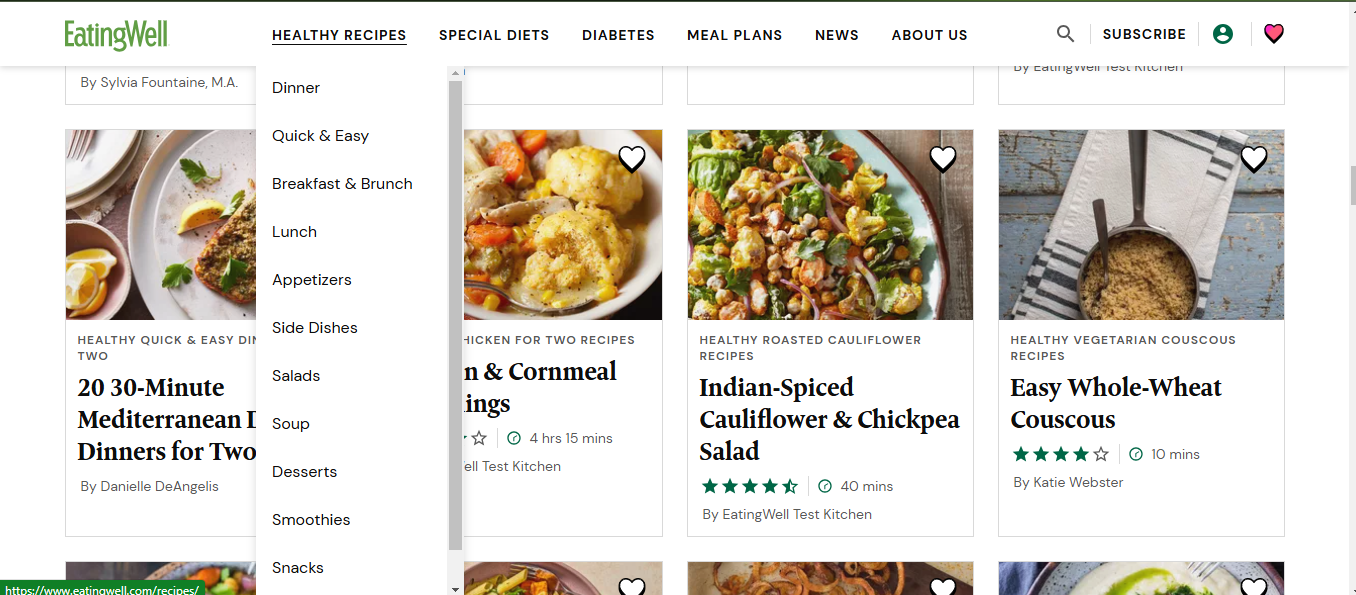

In [ ]:
main = scrap("https://www.eatingwell.com")
sub1main = [i.a["href"] for i in main.find_all("li", class_ = "mntl-fullscreen-nav__sublist-item type--rabbit")][0:27]

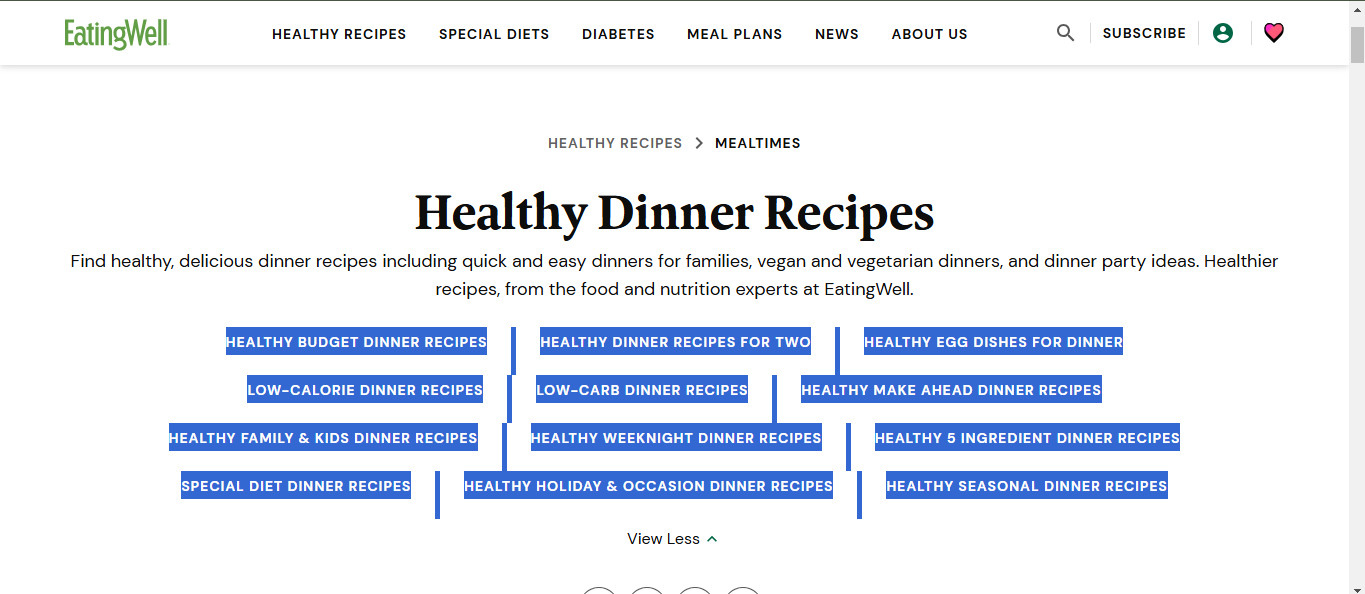

In [ ]:
sub2main = []
for i in sub1main:
  sub2main_scrap(scrap(i))

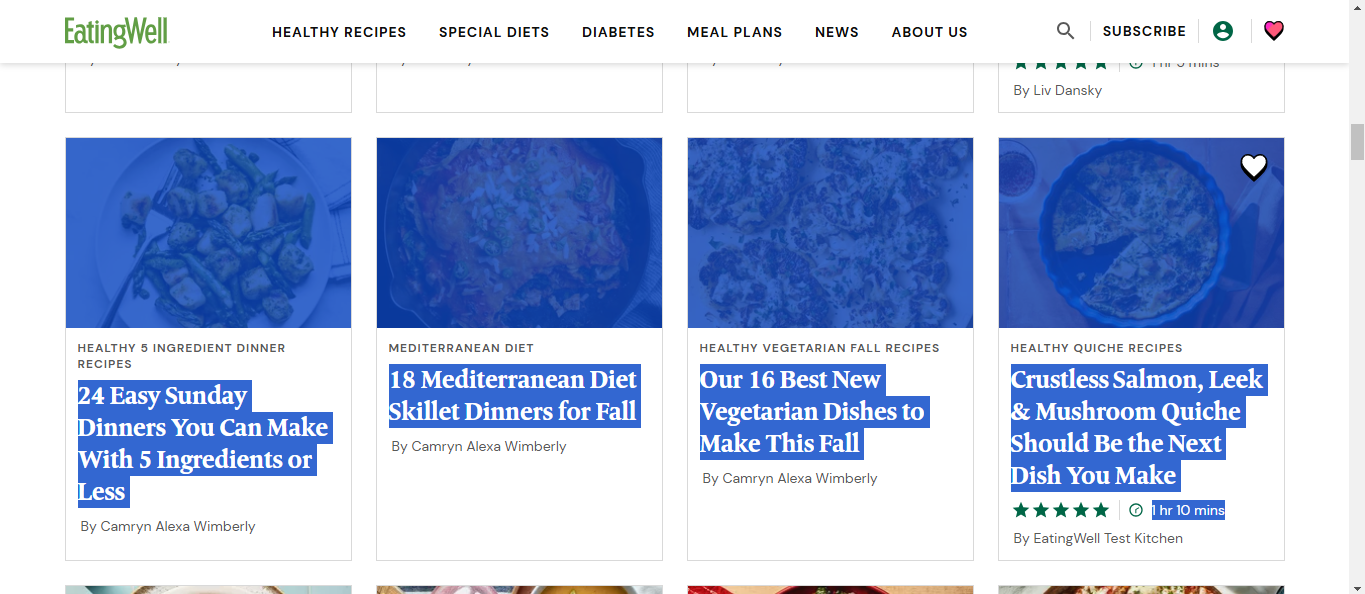

In [ ]:
subfix = sub1main + sub2main
sub3main = []
for i in subfix:
  sub3main_scrap(scrap(i))

# **CSV Aggregrate**

In [ ]:
data = pd.read_csv("Diet Meal Master.csv", encoding = "UTF-8")
data_err = pd.read_csv("err.csv", encoding = "UTF-8")
data = data.drop_duplicates(subset="Link")

link = data["Link"].to_list()
stexe = [i for i in data_err["0"] if i not in link]
to_execute = []
for i in stexe:
  if i not in to_execute:
    to_execute.append(i)
#data.to_csv("Diet Meal Fix.csv")

In [ ]:
len(to_execute)

122

# **Scrap Data**

In [ ]:
err_url = []
new_url = []

for i, j in enumerate(to_execute):
    try:
      gt = scrap_content_in_content(j)
      if len(gt) != 0:
        new_url.append(gt)
        print(i, j)
      else:
        scraping_content = scrap_content(j)
        print(i, scraping_content[6])
    except:
      print("error", j)
      err_url.append(j)

0 {'Total Carbohydrate': '37g', 'Dietary Fiber': '3g', 'Total Sugars': '4g', 'Protein': '13g', 'Total Fat': '14g', 'Saturated Fat': '6g', 'Sodium': '584mg'}
1 {'Total Carbohydrate': '45g', 'Dietary Fiber': '4g', 'Total Sugars': '4g', 'Protein': '24g', 'Total Fat': '9g', 'Saturated Fat': '3g', 'Sodium': '458mg'}
2 {'Total Carbohydrate': '46g', 'Dietary Fiber': '4g', 'Total Sugars': '6g', 'Protein': '25g', 'Total Fat': '11g', 'Saturated Fat': '2g', 'Sodium': '736mg'}
3 {'Total Carbohydrate': '22g', 'Dietary Fiber': '4g', 'Total Sugars': '8g', 'Protein': '11g', 'Total Fat': '16g', 'Saturated Fat': '7g', 'Cholesterol': '31mg', 'Sodium': '445mg'}
4 {'Total Carbohydrate': '42g', 'Dietary Fiber': '11g', 'Total Sugars': '8g', 'Protein': '19g', 'Total Fat': '18g', 'Saturated Fat': '5g', 'Sodium': '570mg'}
5 {'Total Carbohydrate': '56g', 'Dietary Fiber': '8g', 'Total Sugars': '9g', 'Protein': '26g', 'Total Fat': '18g', 'Saturated Fat': '6g', 'Sodium': '659mg'}
6 {'Total Carbohydrate': '24g', 'Di

In [ ]:
#https://www.eatingwell.com/recipes/19301/ingredients/vegetables/eggplant/
#https://www.eatingwell.com/recipe/273181/salmon-burgers-with-quick-pickled-cucumbers/

In [ ]:
data = pd.read_csv("Diet Meal Master.csv", encoding = "UTF-8")
data = data.drop_duplicates(subset="Link")
data.to_csv("Data NLP Fix.csv")

# **Ground Truth**

1. High protein meal for vegetarian
2. Low sugar and less than 150 calories drink suit for diabetic
3. No-bake dessert recipes that are simple and quick to make
4. Provide meal prep recipes designed for weight loss with no seafood
5. Low-carb and high protein meals suitable for keto diet
6. Plant-based recipes high in iron for vegans
7. Low-sodium soups with fresh ingredients
8. 5 star ratings smoothie bowl without banana
9. Fermented drinks for gut health and digestion
10. Low calorie dinner meal with lamb


In [ ]:
import ast
import numpy as np
import pandas as pd

data = pd.read_csv("Data NLP Clean.csv", encoding = "UTF-8")

data["Infomation"] = [ast.literal_eval(i) if isinstance(i, str) and i != 'nan' else np.nan for i in data["Infomation"]]
unique_attributes = set(attr for sublist in data["Infomation"].dropna() for attr in sublist)
for attr in unique_attributes:
    data[attr] = data["Infomation"].apply(lambda x: 1 if isinstance(x, list) and attr in x else 0)
data

,Unnamed: 0.1,Unnamed: 0,Link,Headline,Author Name,Details,Description,Infomation,Nutrition,Serving,...,Heart-Healthy,Soy-Free,Healthy Pregnancy,No Added Sugar,High-Protein,Gluten-Free,Gut Healthy,Low-Carb,Mediterranean Diet,Healthy Aging
0,0,0,https://www.eatingwell.com/eva-longoria-loaded...,Eva Longoria’s 5-Ingredient Loaded Sweet Potatoes,Eva Longoria,"{'Active Time:': '20 mins', 'Total Time:': '1 ...","Eva Longoria’s Loaded Sweet Potatoes, from her...","[No Added Sugar, Sesame-Free, Nut-Free, Soy-Fr...","{'Total Carbohydrate': '34g', 'Dietary Fiber':...","{'Servings Per Recipe': '4', 'Serving Size': '...",...,0,1,0,1,0,1,0,0,0,0
1,1,1,https://www.eatingwell.com/french-onion-cabbag...,French Onion Cabbage Soup Is a Fun Twist on th...,Melissa Gray,"{'Active Time:': '55 mins', 'Total Time:': '1 ...",This French onion cabbage soup is a creative t...,"[No Added Sugar, Gut Healthy, Mediterranean Di...","{'fat': '19g', 'saturated fat': '5g', 'cholest...",{'Serving Size': ' about 1½ cups soup & ¾ cup ...,...,0,0,0,1,0,0,1,0,1,0
2,2,2,https://www.eatingwell.com/cheesy-cabbage-grat...,Making Cheesy Cabbage Gratin Is Worth the Effort,Julia Levy,"{'Active Time:': '40 mins', 'Total Time:': '1 ...",This cheesy cabbage gratin puts a fresh spin o...,"[No Added Sugar, Sesame-Free, Nut-Free, Soy-Fr...","{'Total Carbohydrate': '14g', 'Dietary Fiber':...","{'Servings Per Recipe': '8', 'Serving Size': '...",...,0,1,0,1,0,1,0,0,0,0
3,3,3,https://www.eatingwell.com/pumpkin-summer-squa...,Pumpkin-Summer Squash Ravioli with Brown Butte...,Julia Levy,"{'Active Time:': '35 mins', 'Total Time:': '45...",This squash ravioli is like traditional raviol...,"[No Added Sugar, Sesame-Free, Soy-Free, Vegeta...","{'Total Carbohydrate': '16g', 'Dietary Fiber':...","{'Servings Per Recipe': '4', 'Serving Size': '...",...,0,1,0,1,0,1,0,0,0,0
4,4,4,https://www.eatingwell.com/orange-chicken-broc...,This Orange Chicken &amp; Broccoli Skillet Is ...,Liv Dansky,"{'Active Time:': '30 mins', 'Total Time:': '1 ...",This protein-packed orange chicken and broccol...,"[Mediterranean Diet, Nut-Free, Dairy-Free, Hig...","{'fat': '29g', 'saturated fat': '7g', 'cholest...",{'Serving Size': ' 1 chicken thigh & about ¾ c...,...,0,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5180,5180,6802,https://www.eatingwell.com/recipe/276941/slow-...,Slow-Cooker Korean Beef &amp; Cabbage Stew,EatingWell Test Kitchen,"{'Prep Time:': '25 mins', 'Additional Time:': ...",Brown sugar makes this slow-cooker beef stew a...,NaN,"{'Total Carbohydrate': '11g', 'Dietary Fiber':...","{'Servings Per Recipe': '8', 'Serving Size': '...",...,0,0,0,0,0,0,0,0,0,0
5181,5181,6803,https://www.eatingwell.com/recipe/7870055/crea...,One-Pot Creamy Vegetable Soup,Julia Levy,"{'Active Time:': '45 mins', 'Total Time:': '45...",This creamy vegetarian soup recipe is brimming...,NaN,"{'Total Carbohydrate': '46g', 'Dietary Fiber':...","{'Servings Per Recipe': '6', 'Serving Size': '...",...,0,0,0,0,0,0,0,0,0,0
5182,5182,6804,https://www.eatingwell.com/recipe/276922/slow-...,Slow-Cooker Carrot-Leek Bisque,EatingWell Test Kitchen,"{'Prep Time:': '20 mins', 'Additional Time:': ...",Creamy and delicate slow-cooker carrot soup is...,NaN,"{'Total Carbohydrate': '18g', 'Dietary Fiber':...","{'Servings Per Recipe': '12', 'Serving Size': ...",...,0,0,0,0,0,0,0,0,0,0
5183,5183,6805,https://www.eatingwell.com/recipe/276953/slow-...,Slow-Cooker Italian Vegetable &amp; Farro Soup,EatingWell Test Kitchen,"{'Prep Time:': '30 mins', 'Additional Time:': ...",The farro­­an ancient whole grain rich in iron...,NaN,"{'Total Carbohydrate': '31g', 'Dietary Fiber':...","{'Servings Per Recipe': '8', 'Serving Size': '...",...,0,0,0,0,0,0,0,0,0,0


In [ ]:
cal = []
for i, j in enumerate(data["Serving"]):
  try:
    cal.append(int(ast.literal_eval(str(j))["Calories"]))
  except:
    try:
      cal.append(int(ast.literal_eval(str(j))["calories"]))
    except:
      print(i,j)
      cal.append(8888)

data["Calories"] = cal

97 {'Serving Size': ' 5 to 6 pieces'}
2287 {}
2288 {}
2366 {'Servings Per Recipe': '12'}
2765 {'Servings Per Recipe': '6', 'Serving Size': '1/3 cup'}
3231 {'Serving Size': ' 1 3/4 cups'}
5184 nan


In [ ]:
iron = []
for i, j in enumerate(data["Nutrition"]):
  try:
    iron.append(int(ast.literal_eval(str(j))["Iron"].replace("mg", "")))
  except:
    try:
      iron.append(int(ast.literal_eval(str(j))["iron"].replace("mg", "")))
    except:
      iron.append(8888)

data["Iron"] = iron

In [ ]:
carb = []
for i, j in enumerate(data["Nutrition"]):
  try:
    carb.append(int(ast.literal_eval(j)["Total Carbohydrate"].replace("g", "")))
  except:
    try:
      carb.append(int(ast.literal_eval(j)["carbohydrates"].replace("g", "")))
    except:
      carb.append(8888)

data["Carb"] = carb

In [ ]:
protein = []
for i, j in enumerate(data["Nutrition"]):
  try:
    protein.append(int(ast.literal_eval(j)["Protein"].replace("g", "")))
  except:
    try:
      protein.append(int(ast.literal_eval(j)["protein"].replace("g", "")))
    except:
      protein.append(8888)

data["Protein"] = protein

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5185 entries, 0 to 5184
Data columns (total 53 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Unnamed: 0.1         5185 non-null   int64  
 1   Unnamed: 0           5185 non-null   int64  
 2   Link                 5185 non-null   object 
 3   Headline             5185 non-null   object 
 4   Author Name          5185 non-null   object 
 5   Details              5184 non-null   object 
 6   Description          5185 non-null   object 
 7   Infomation           5137 non-null   object 
 8   Nutrition            5184 non-null   object 
 9   Serving              5184 non-null   object 
 10  Rating               5185 non-null   float64
 11  Rating Count         5185 non-null   int64  
 12  Category             5185 non-null   object 
 13  Cuisine              1513 non-null   object 
 14  Ingredients          5185 non-null   object 
 15  Instruction          5185 non-null   o

In [ ]:
a

NameError: name 'a' is not defined

## **High protein meal for vegetarian**

In [ ]:
filtered_data1 = data[(data["Vegan"] == 1) | (data["Vegetarian"] == 1)]
filtered_data1 = data[(data["High-Protein"] == 1)]
filtered_data1

In [ ]:
pd.DataFrame({"idx": filtered_data1.index}).to_excel("q1.xlsx")

## **Low sugar and less than 150 calories drink suit for diabetic**

In [ ]:
filtered_data2 = data[(data["No Added Sugar"] == 1) | (data["Low Added Sugar"] == 1) | (data["Diabetes-Friendly"] == 1)]
key = ["drink", "beverage", "brew", "liquor", "cocktail", "mocktail", "tea"]
idx = [z for z, i in enumerate(filtered_data2["Description"]) if any(j in i.lower() for j in key)]
filtered_data2 = filtered_data2.iloc[idx][filtered_data2["Calories"] <= 150]
filtered_data2

In [ ]:
idx

In [ ]:
filtered_data2 = pd.read_csv("filtered_data2.csv")
to_drop = [165, 304, 591, 690, 698, 733, 896, 922, 968, 980,
           1111, 1121, 1199, 1252, 1273, 1366, 1393, 1412, 1620, 1639,
           1668, 1706, 1771, 1780, 1794, 1802, 1805, 1957, 1961, 1965, 1966,
           1968, 1977, 2031, 2041, 2057, 2088, 2185, 2225, 2262, 2391, 2420,
           2424, 2507, 2510, 2838, 2841, 2842, 2866, 3256, 3425, 3445, 3534,
           3543, 3865, 4007, 4113, 4147, 4466, 4467, 4470, 4761, 4792, 4798,
           5010, 5162, 5163]
filtered_data2 = filtered_data2[~filtered_data2["Unnamed: 0.2"].isin(to_drop)]
filtered_data2

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,Link,Headline,Author Name,Details,Description,Infomation,Nutrition,...,Paleo,Sesame-Free,Soy-Free,Vegan,Vegetarian,Weight Loss,Whole30,a,n,Calories
1,253,253,253,https://www.eatingwell.com/recipe/259625/carro...,Carrot Smoothie,EatingWell Test Kitchen,"{'Prep Time:': '10 mins', 'Additional Time:': ...",This type of drink tends to be pricey in the b...,"['Low-Carb', 'Diabetes-Friendly', 'Nut-Free', ...","{'Total Carbohydrate': '13g', 'Dietary Fiber':...",...,0,0,1,1,1,0,0,0,0,55
7,858,858,858,https://www.eatingwell.com/recipe/263103/homem...,Homemade Almond Milk,Michelle Edelbaum,"{'Prep Time:': '15 mins', 'Additional Time:': ...","This almond milk is so creamy and flavorful, y...","['Low-Carb', 'Dairy-Free', 'Low-Fat', 'Soy-Fre...","{'Total Carbohydrate': '1g', 'Dietary Fiber': ...",...,0,0,1,1,1,0,0,0,0,10
8,886,886,886,https://www.eatingwell.com/recipe/8018333/froz...,Frozen Lemon-Ginger-Turmeric Shots,Catherine Jessee,"{'Active Time:': '10 mins', 'Total Time:': '1 ...",When hot water is poured over these frozen lem...,"['Diabetes-Friendly', 'Nut-Free', 'Dairy-Free'...","{'Total Carbohydrate': '10g', 'Total Sugars': ...",...,0,0,1,0,1,0,0,0,0,38
21,1578,1578,1578,https://www.eatingwell.com/recipe/267226/berry...,Berry-Mint Kefir Smoothies,"Andrea Kirkland, M.S., RD","{'Prep Time:': '5 mins', 'Total Time:': '5 min...","Kefir is similar to yogurt, full of gut-friend...","['Diabetes-Friendly', 'Nut-Free', 'Low-Fat', '...","{'Total Carbohydrate': '27g', 'Dietary Fiber':...",...,0,0,1,0,1,0,0,0,0,137
23,1635,1635,1635,https://www.eatingwell.com/recipe/250927/radis...,Radish Tea Sandwiches with Creamy Dill Spread,"Breana Lai Killeen, M.P.H., RD","{'Cook Time:': '20 mins', 'Total Time:': '20 m...",In this radish tea sandwich recipe with a crea...,"['Low-Carb', 'Diabetes-Friendly', 'Low-Sodium'...","{'Total Carbohydrate': '8g', 'Dietary Fiber': ...",...,0,0,0,0,1,0,0,0,0,84
41,2067,2067,2067,https://www.eatingwell.com/recipe/275479/mojit...,Mojito Blueberry &amp; Watermelon Salad,Carolyn Casner,"{'Prep Time:': '10 mins', 'Additional Time:': ...","Inspired by the classic mojito cocktail, this ...","['Diabetes-Friendly', 'Nut-Free', 'Dairy-Free'...","{'Total Carbohydrate': '16g', 'Dietary Fiber':...",...,0,0,1,1,1,0,0,0,0,68
51,2539,2539,2539,https://www.eatingwell.com/recipe/249722/chunk...,Chunky Peach Popsicles,Virginia Willis,"{'Cook Time:': '15 mins', 'Additional Time:': ...",Make sure to reserve a portion of the peaches ...,"['Low-Carb', 'Diabetes-Friendly', 'Dairy-Free'...","{'Total Carbohydrate': '10g', 'Dietary Fiber':...",...,0,0,0,1,0,0,0,0,0,39
52,2731,2731,2731,https://www.eatingwell.com/recipe/281283/whipp...,Whipped Frozen Cherry Limeade,Casey Barber,"{'Prep Time:': '10 mins', 'Additional Time:': ...",How can you possibly make whipped frozen limea...,"['Low-Carb', 'Nut-Free', 'Soy-Free', 'Vegetari...","{'Total Carbohydrate': '15g', 'Dietary Fiber':...",...,0,0,1,0,1,0,0,0,0,57
53,2755,2755,2755,https://www.eatingwell.com/recipe/273396/straw...,Strawberry Shrub,Adam Dolge,"{'Active Time:': '5 mins', 'Additional Time:':...",Shrubs (vinegar-based syrups) add sweetness an...,"['Low-Carb', 'Diabetes-Friendly', 'Nut-Free', ...","{'Total Carbohydrate': '13g', 'Dietary Fiber':...",...,0,0,1,1,1,0,0,0,0,52
54,2756,2756,2756,https://www.eatingwell.com/recipe/249905/orang...,Orange-Earl Grey Iced Tea,Hilary Meyer,"{'Cook Time:': '10 mins', 'Additional Time:': ...",Get a little pick-me-up with this orange-infus...,"['Low-Carb', 'Diabetes-Friendly', 'Dairy-Free'...","{'Total Carbohydrate': '9g', 'Dietary Fiber': ...",...,0,0,0,0,0,0,0,0,0,35


In [ ]:
pd.DataFrame({"idx": filtered_data2.index}).to_excel("q2.xlsx")

## **No-bake dessert recipes that are simple and quick to make**

In [ ]:
dessert = [
    "dessert", "cake", "pudding", "pastry", "ice cream",
    "custard", "sorbet", "mousse", "tart", "cupcake", "cheesecake",
    "gateau", "pie", "torte", "brownie", "sponge", "muffin", "flan",
    "confection", "confectionery", "candy", "bonbon", "truffle",
    "chocolate", "marzipan", "jelly", "gelato", "fudge", "parfait",
    "strudel", "churros", "baklava", "panna cotta", "rugelach", "eclair",
    "creme brulee"
]
exclude_1 = [
    "fish", "crab", "shrimp", "lobster", "prawn",
    "oyster", "scallop", "clam", "mussel", "squid",
    "octopus", "tuna", "salmon", "cod", "halibut",
    "snapper", "mackerel", "trout", "sardine",
    "anchovy", "eel", "tilapia", "bass", "sea urchin",
    "kingfish", "yellowtail", "flounder", "perch", "ray fish",
    "sturgeon", "bluefish", "swai", "pollock", "mahi-mahi",
    "beef", "chicken", "pork", "lamb", "goat", "duck",
    "eggplant", "garlic", "bell pepper", "spinach",
    "broccoli", "cauliflower", "asparagus", "kale", "onion", "garlic", "leek",
    "green beans", "cabbage", "mushroom", "artichoke", "chicken", "beef", "pork",
    "lamb", "goat", "duck", "venison", "rabbit", "goose", "bacon",
    "sausage", "ham", "salami", "pepperoni", "veal", "seafood"]

to_exclude = ["with oven", "bake", "baking", "tortellini"]
pattern = '|'.join(dessert)
pattern2 = '|'.join(to_exclude)
pattern3 = '|'.join(exclude_1)
filtered_data3 = data[data["Headline"].str.lower().str.contains(pattern, na=False)]
filtered_data3 = filtered_data3[~filtered_data3["Headline"].str.lower().str.contains(pattern3, na=False)]
filtered_data3 = filtered_data3[~filtered_data3["Instruction"].str.lower().str.contains(pattern2, na=False)]

filtered_data3

In [ ]:
for i,j in zip(filtered_data3["Headline"], filtered_data3["Description"]):
  print(i, "Desc:", j)

## **Provide meal prep recipes designed for weight loss with no seafood**

In [ ]:
filtered_data4 = data[(data["Weight Loss"] == 1)]
seafood = [
    "fish", "crab", "shrimp", "lobster", "prawn",
    "oyster", "scallop", "clam", "mussel", "squid",
    "octopus", "tuna", "salmon", "cod", "halibut",
    "snapper", "mackerel", "trout", "sardine",
    "anchovy", "eel", "tilapia", "bass", "sea urchin",
    "kingfish", "yellowtail", "flounder", "perch", "ray fish",
    "sturgeon", "bluefish", "swai", "pollock", "mahi-mahi"
]

pattern = '|'.join(seafood)
filtered_data4 = filtered_data4[~filtered_data4["Ingredients"].str.lower().str.contains(pattern, na=False)]
filtered_data4 = filtered_data4[filtered_data4["Category"].apply(lambda x: ast.literal_eval(x) != "Dessert")]
filtered_data4

## **Low-carb and high protein meals suitable for keto diet**

In [ ]:
filtered_data5 = data[(data["Low-Fat"] == 0) & (data["Low-Carb"] == 1)]
filtered_data5 = data[(data["High-Protein"] == 0)]
foods_to_avoid = ["rice", "bread", "pasta", "potato", "corn", "yam", "cassava", "sweet potato", "sweet", "candy", "cake", "banana", "mango", "grape"]
pattern = '|'.join(foods_to_avoid)
filtered_data5 = filtered_data5[~filtered_data5["Description"].str.lower().str.contains(pattern, na=False)]
#filtered_data5 = filtered_data5[filtered_data5["Category"].apply(lambda x: ast.literal_eval(x) != "Dessert")]
filtered_data5.sort_values("Carb")

## **Plant-based recipes high in iron for vegans**

In [ ]:
filtered_data6 = data[(data["Vegan"] == 1)]
filtered_data6 = filtered_data6.sort_values("Iron", ascending = False)
filtered_data6 = filtered_data6[~filtered_data6["Iron"].isin([0, 8888])]
filtered_data6 = filtered_data6[filtered_data6["Iron"] > 5]
filtered_data6

In [ ]:
gt_1, gt_2, gt_3, gt_4, gt_5 = filtered_data1.index.to_list(), filtered_data2.index.to_list(), filtered_data3.index.to_list(), filtered_data4.index.to_list(), filtered_data5.index.to_list()
lgt_1, lgt_2, lgt_3, lgt_4, lgt_5 = len(gt_1), len(gt_2), len(gt_3), len(gt_4), len(gt_5)

## **Low-sodium soups with fresh ingredients**

In [ ]:
filtered_data7 = data[(data["Low-Sodium"] == 1)]
idx = [z for z, i in enumerate(filtered_data7["Headline"]) if "soup" in i.lower()]
filtered_data7.iloc[idx]

## **Up to 4.5 star ratings smoothie bowl with banana**

In [ ]:
data["Rating"] = pd.to_numeric(data["Rating"], errors="coerce")
filtered_data8 = data[data["Rating"] > 4.5]
fil = ["smooothie", "smoothies"]
idx = [z for z, i in enumerate(filtered_data8["Description"]) if any(j in i.lower() for j in fil)]
idx2 = [z for z, i in enumerate(filtered_data8.iloc[idx]["Ingredients"]) if "banana" in i.lower()]
result = filtered_data8.iloc[idx].iloc[idx2]
result

## **Fermented drinks for gut health and digestion**

In [ ]:
fermented_drinks = [
    "kombucha", "kefir", "buttermilk", "lassi", "yakult", "kvass", "ginger Bug",
    "fermented Lemonade", "probiotic juice", "prebiotic drink", "beet Kvass",
    "yogurt"]

idx = [z for z, i in enumerate(data["Headline"]) if any(j in i.lower() for j in fermented_drinks)]
filtered_data9 = pd.read_csv("filtered_data9.csv")
idx2 = [z for z, i in enumerate(filtered_data9["Unnamed: 0"]) if i in [245, 251, 672, 1573, 1578, 2697, 2758, 4447, 4449, 4864]]
filtered_data9 = filtered_data9.iloc[idx2]
filtered_data9

## **Low calorie dinner meal with lamb**

In [ ]:
filtered_data10 = data[data["Low-Calorie"] == 1]
idx = [z for z, i in enumerate(filtered_data10["Ingredients"]) if "lamb" in i.lower()]
filtered_data10.iloc[idx]

In [ ]:
def svcsv(name, title):
  return pd.DataFrame({"Headlines": name["Headline"]}).to_csv(title + ".csv")

In [ ]:
for i in range (1, 11):
  name = globals().get(f"filtered_data{i}")
  if name is not None:
      svcsv(name, f"question{i}")

# **Preprocessing**

In [ ]:
!pip install emoji
import pandas as pd
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import spacy
from textblob import TextBlob,Word
import emoji
import re
import torch

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [ ]:
data = pd.read_csv("/content/Data NLP Clean.csv")
data = data.drop(["Unnamed: 0.1", "Unnamed: 0", "To Train"], axis = 1)
data

,Link,Headline,Author Name,Details,Description,Infomation,Nutrition,Serving,Rating,Rating Count,Category,Cuisine,Ingredients,Instruction
0,https://www.eatingwell.com/eva-longoria-loaded...,Eva Longoria’s 5-Ingredient Loaded Sweet Potatoes,Eva Longoria,"{'Active Time:': '20 mins', 'Total Time:': '1 ...","Eva Longoria’s Loaded Sweet Potatoes, from her...","['No Added Sugar', 'Sesame-Free', 'Nut-Free', ...","{'Total Carbohydrate': '34g', 'Dietary Fiber':...","{'Servings Per Recipe': '4', 'Serving Size': '...",5.0,1,['Dinner'],['American'],"['4 large sweet potatoes', '6 slices bacon', '...",['Preheat the oven to 400℉. Line a baking shee...
1,https://www.eatingwell.com/french-onion-cabbag...,French Onion Cabbage Soup Is a Fun Twist on th...,Melissa Gray,"{'Active Time:': '55 mins', 'Total Time:': '1 ...",This French onion cabbage soup is a creative t...,"['No Added Sugar', 'Gut Healthy', 'Mediterrane...","{'fat': '19g', 'saturated fat': '5g', 'cholest...",{'Serving Size': ' about 1½ cups soup & ¾ cup ...,5.0,2,"['Dinner', 'Entree']",['American'],"['6 tablespoons vegetable oil, divided', '1 sm...",['Heat 2 tablespoons oil in a large Dutch oven...
2,https://www.eatingwell.com/cheesy-cabbage-grat...,Making Cheesy Cabbage Gratin Is Worth the Effort,Julia Levy,"{'Active Time:': '40 mins', 'Total Time:': '1 ...",This cheesy cabbage gratin puts a fresh spin o...,"['No Added Sugar', 'Sesame-Free', 'Nut-Free', ...","{'Total Carbohydrate': '14g', 'Dietary Fiber':...","{'Servings Per Recipe': '8', 'Serving Size': '...",5.0,2,['Dinner'],['American'],"['1 (2¼–2½ pound) head Savoy or green cabbage,...","['Preheat oven to 350°F. Coat a 3-quart oval, ..."
3,https://www.eatingwell.com/pumpkin-summer-squa...,Pumpkin-Summer Squash Ravioli with Brown Butte...,Julia Levy,"{'Active Time:': '35 mins', 'Total Time:': '45...",This squash ravioli is like traditional raviol...,"['No Added Sugar', 'Sesame-Free', 'Soy-Free', ...","{'Total Carbohydrate': '16g', 'Dietary Fiber':...","{'Servings Per Recipe': '4', 'Serving Size': '...",5.0,2,['Dinner'],['American'],"['1¼ pounds yellow summer squash, trimmed (abo...",['Preheat oven to 425°F with racks in top thir...
4,https://www.eatingwell.com/orange-chicken-broc...,This Orange Chicken &amp; Broccoli Skillet Is ...,Liv Dansky,"{'Active Time:': '30 mins', 'Total Time:': '1 ...",This protein-packed orange chicken and broccol...,"['Mediterranean Diet', 'Nut-Free', 'Dairy-Free...","{'fat': '29g', 'saturated fat': '7g', 'cholest...",{'Serving Size': ' 1 chicken thigh & about ¾ c...,5.0,3,['Dinner'],['American'],"['1 tablespoon canola oil', '6 (6-ounce) bone-...",['Preheat oven to 350°F. Heat 1 tablespoon oil...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5180,https://www.eatingwell.com/recipe/276941/slow-...,Slow-Cooker Korean Beef &amp; Cabbage Stew,EatingWell Test Kitchen,"{'Prep Time:': '25 mins', 'Additional Time:': ...",Brown sugar makes this slow-cooker beef stew a...,NaN,"{'Total Carbohydrate': '11g', 'Dietary Fiber':...","{'Servings Per Recipe': '8', 'Serving Size': '...",5.0,1,[],NaN,"['1 tablespoon canola oil', '1 (2 pound) bonel...",['Heat the oil in a large nonstick skillet ove...
5181,https://www.eatingwell.com/recipe/7870055/crea...,One-Pot Creamy Vegetable Soup,Julia Levy,"{'Active Time:': '45 mins', 'Total Time:': '45...",This creamy vegetarian soup recipe is brimming...,NaN,"{'Total Carbohydrate': '46g', 'Dietary Fiber':...","{'Servings Per Recipe': '6', 'Serving Size': '...",0.0,0,[],NaN,"['2 tablespoons extra-virgin olive oil', '1.5 ...",['Heat oil in a large heavy pot over medium-hi...
5182,https://www.eatingwell.com/recipe/276922/slow-...,Slow-Cooker Carrot-Leek Bisque,EatingWell Test Kitchen,"{'Prep Time:': '20 mins', 'Additional Time:': ...",Creamy and delicate slow-cooker carrot soup is...,NaN,"{'Total Carbohydrate': '18g', 'Dietary Fiber':...","{'Servings Per Recipe': '12', 'Serving Size': ...",5.0,2,[],NaN,"['1 tablespoon canola oil', '1 tablespoon dry ...",['Heat the oil in a 

In [ ]:
def decontracted(phrase):
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"let\'s", "let us", phrase)
    phrase = re.sub(r"ain\'t", "is not", phrase)

    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    phrase = re.sub(r"y\'all", "you all", phrase)
    phrase = re.sub(r"ma\'am", "madam", phrase)
    phrase = re.sub(r"o\'clock", "of the clock", phrase)
    phrase = re.sub(r"e\'er", "ever", phrase)
    phrase = re.sub(r"\'tis", "it is", phrase)
    phrase = re.sub(r"\'twas", "it was", phrase)
    return phrase

def negation(sentence):
  sentence = sentence.split(" ")
  temp = int(0)
  for i in range(len(sentence)):
      if sentence[i-1] in ["not","n't"]:
          antonyms = []
          for syn in wordnet.synsets(sentence[i]):
              syns = wordnet.synsets(sentence[i])
              w1 = syns[0].name()
              temp = 0
              for l in syn.lemmas():
                  if l.antonyms():
                      antonyms.append(l.antonyms()[0].name())
              max_dissimilarity = 0
              for ant in antonyms:
                  syns = wordnet.synsets(ant)
                  w2 = syns[0].name()
                  syns = wordnet.synsets(sentence[i])
                  w1 = syns[0].name()
                  word1 = wordnet.synset(w1)
                  word2 = wordnet.synset(w2)
                  if isinstance(word1.wup_similarity(word2), float) or isinstance(word1.wup_similarity(word2), int):
                      temp = 1 - word1.wup_similarity(word2)
                  if temp > max_dissimilarity:
                      max_dissimilarity = temp
                      antonym_max = ant
                      sentence[i] = antonym_max
                      sentence[i-1] = ""
  while "" in sentence:
      sentence.remove("")
  return " ".join(sentence)

In [ ]:
def preprocess_en(text):
  text = decontracted(str(text).lower())
  # text = negation(text)
  spacy_en = spacy.load('en_core_web_sm')
  #text = [token.text for token in spacy_en(text)]
  #text = [i for i in text if not i in stopwords.words('english')]
  #text = " ".join([Word(word).lemmatize("v") for word in text])
  cleaned = re.sub(r"[,\./\[\]{}=+@'\"*]", "", text)
  cleaned = emoji.demojize(cleaned)
  cleaned = cleaned.replace("\r", "").replace("\n", " ").replace("\n", " ")
  print(cleaned)
  return cleaned

In [ ]:
data.columns

Index(['Link', 'Headline', 'Author Name', 'Details', 'Description',
       'Infomation', 'Nutrition', 'Serving', 'Rating', 'Rating Count',
       'Category', 'Cuisine', 'Ingredients', 'Instruction'],
      dtype='object')

In [ ]:
def clean_text(text):
  return re.sub(r'-', ' ', re.sub(r'[^\w\s-]', '', str(text).lower()))

var1 = ["Headline", "Details", "Description", "Infomation", "Nutrition", "Category", "Cuisine"]
for i in var1:
  data[i] = data[i].apply(clean_text)

data["Author Name"] = data["Author Name"].apply(lambda x: "by" + x.lower())
data["Serving"] = data["Serving"].apply(lambda x: re.sub(r'-', ' ', re.sub(r'[^\w\s/-]', '', str(x).lower())))
data["Rating"] = data["Rating"].apply(lambda x: "{} of 5 rating".format(x))
data["Rating Count"] = data["Rating Count"].apply(lambda x: "out of {} reviewers".format(x))
data["Ingredients"] = [re.sub(r'-', ' ', re.sub(r'[^\w\s/.,°-]', '', str(x).lower()))  for x in data["Ingredients"]]
data["Instruction"] = [re.sub(r'-', ' ', re.sub(r'[^\w\s/.,°-]', '', str(x).lower()))  for x in data["Instruction"]]

In [ ]:
gather1 = []
for i in range(data.shape[0]):
  gather2 = []
  for j in data.columns:
    gather2.append(str(data[j][i]))
  gather1.append(" ".join(gather2))
data["Summary"] = gather1

In [ ]:
data["Summary"]

,Summary
0,https://www.eatingwell.com/eva-longoria-loaded...
1,https://www.eatingwell.com/french-onion-cabbag...
2,https://www.eatingwell.com/cheesy-cabbage-grat...
3,https://www.eatingwell.com/pumpkin-summer-squa...
4,https://www.eatingwell.com/orange-chicken-broc...
...,...
5180,https://www.eatingwell.com/recipe/276941/slow-...
5181,https://www.eatingwell.com/recipe/7870055/crea...
5182,https://www.eatingwell.com/recipe/276922/slow-...
5183,https://www.eatingwell.com/recipe/276953/slow-...


In [ ]:
"""data["To Train"] = ["".join(str(i)) for i in to_train]
data["To Train"] = data["To Train"].apply(preprocess_en)"""

'data["To Train"] = ["".join(str(i)) for i in to_train]\ndata["To Train"] = data["To Train"].apply(preprocess_en)'

In [ ]:
data.to_csv("Data NLP Clean 2.csv")

In [ ]:
s

NameError: name 's' is not defined

# **Modeling**

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
!pip install rank_bm25
from rank_bm25 import BM25Okapi
from nltk.tokenize import word_tokenize

In [ ]:
meal_ideas = pd.read_excel("/content/List Query NLP (1).xlsx", sheet_name = "Kode")
meal_ideas = meal_ideas["Question"].iloc[:40]

In [ ]:
datagt = pd.read_excel("/content/List Query NLP (1).xlsx", sheet_name = "Index Ground Truth")
datagt = datagt.iloc[:, :40]
datagt = datagt.astype('int', errors='ignore')
datagt

In [ ]:
def calculate_precision(result, truth, total):
  return len([i for i in result.index if i in truth])/total

def calculate_recall(result, truth):
  result_set = set(result.index)
  truth_set = set(truth.dropna())
  return len(result_set & truth_set) / len(truth_set)

## **TF-IDF**

In [ ]:
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(data["Summary"])

In [ ]:
def tf_sim(query, output):
  question_vector = vectorizer.transform([query.lower()])
  similarity_scores = cosine_similarity(question_vector, tfidf_matrix).flatten()
  top_result = data.iloc[pd.Series(similarity_scores).sort_values(ascending = False).index[:output]]
  return top_result

In [ ]:
result_tf_1 = tf_sim(meal_ideas[0], 25)
result_tf_2 = tf_sim(meal_ideas[1], 25)
result_tf_3 = tf_sim(meal_ideas[2], 25)
result_tf_4 = tf_sim(meal_ideas[3], 25)
result_tf_5 = tf_sim(meal_ideas[4], 25)
result_tf_6 = tf_sim(meal_ideas[5], 25)
result_tf_7 = tf_sim(meal_ideas[6], 25)
result_tf_8 = tf_sim(meal_ideas[7], 25)
result_tf_9 = tf_sim(meal_ideas[8], 25)
result_tf_10 = tf_sim(meal_ideas[9], 25)

In [ ]:
precision = []
recall = []

for i in range(1, 11):
    result_tf = globals().get(f'result_tf_{i}')
    truth = datagt[f"q{i+10}"]

    precision.append(calculate_precision(result_tf, truth))
    recall.append(calculate_recall(result_tf, truth))

tf_eval = pd.DataFrame({"Question": meal_ideas, "Precision": precision, "Recall": recall})
tf_eval

## **BM25**

In [ ]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [ ]:
corpus = data["Summary"].to_list()
tokenized_corpus = [word_tokenize(doc) for doc in corpus]
bm25 = BM25Okapi(tokenized_corpus)

In [ ]:
def bm25_sim(query, output):
  tokenized_query = word_tokenize(query.lower())
  scores = bm25.get_scores(tokenized_query)
  top_result = data.iloc[pd.Series(scores).sort_values(ascending = False).index[:output]]
  return top_result

results_bm_5 = [bm25_sim(idea, 5) for idea in meal_ideas]
results_bm_10 = [bm25_sim(idea, 10) for idea in meal_ideas]
results_bm_20 = [bm25_sim(idea, 20) for idea in meal_ideas]

In [ ]:
precision = []
recall = []

for i in range(0, 40):
    result_bm = results_bm_5[i]
    truth = datagt[f"q{i+1}"].dropna()

    precision.append(calculate_precision(result_bm, truth, 5))
    recall.append(calculate_recall(result_bm, truth))

bm25_eval_5 = pd.DataFrame({"Question": meal_ideas, "Precision": precision, "Recall": recall})
bm25_eval_5

,Question,Precision,Recall
0,any dinner recipes?,0.0,0.008319
1,Which recipes include both chicken and broccol...,0.0,0.000000
2,Are there nut-free recipes?,1.0,0.001081
3,Gluten-free recipes for diet,0.4,0.000658
4,Vegan dinner recipes categorized as low-carb,0.0,0.000000
5,High-protein recipes containing quinoa as a pr...,0.0,0.045455
6,asian dinner food,0.2,0.000000
7,Dessert from America,0.0,0.000000
8,Dishes free from added sugar,0.8,0.000908
9,Dessert with chocolate,0.0,0.130435


In [ ]:
precision = []
recall = []

for i in range(0, 40):
    result_bm = results_bm_10[i]
    truth = datagt[f"q{i+1}"].dropna()

    precision.append(calculate_precision(result_bm, truth, 10))
    recall.append(calculate_recall(result_bm, truth))

bm25_eval_10 = pd.DataFrame({"Question": meal_ideas, "Precision": precision, "Recall": recall})
bm25_eval_10

,Question,Precision,Recall
0,any dinner recipes?,0.0,0.016639
1,Which recipes include both chicken and broccol...,0.0,0.500000
2,Are there nut-free recipes?,0.9,0.001946
3,Gluten-free recipes for diet,0.3,0.002633
4,Vegan dinner recipes categorized as low-carb,0.0,0.000000
5,High-protein recipes containing quinoa as a pr...,0.0,0.090909
6,asian dinner food,0.2,0.000000
7,Dessert from America,0.0,0.012048
8,Dishes free from added sugar,0.9,0.002043
9,Dessert with chocolate,0.0,0.173913


In [ ]:
precision = []
recall = []

for i in range(0, 40):
    result_bm = results_bm_20[i]
    truth = datagt[f"q{i+1}"].dropna()

    precision.append(calculate_precision(result_bm, truth, 20))
    recall.append(calculate_recall(result_bm, truth))

bm25_eval_20 = pd.DataFrame({"Question": meal_ideas, "Precision": precision, "Recall": recall})
bm25_eval_20

,Question,Precision,Recall
0,any dinner recipes?,0.20,0.023295
1,Which recipes include both chicken and broccol...,0.00,1.000000
2,Are there nut-free recipes?,0.90,0.003891
3,Gluten-free recipes for diet,0.40,0.005925
4,Vegan dinner recipes categorized as low-carb,0.00,0.000000
5,High-protein recipes containing quinoa as a pr...,0.00,0.113636
6,asian dinner food,0.15,0.002119
7,Dessert from America,0.00,0.060241
8,Dishes free from added sugar,0.85,0.004312
9,Dessert with chocolate,0.00,0.391304


In [ ]:
bm_eval_all = pd.DataFrame({
    "Metric": ["p5", "r5", "p10", "r10", "p20", "r20"],
    "Value": [
        bm25_eval_5["Precision"].mean(), bm25_eval_5["Recall"].mean(),
        bm25_eval_10["Precision"].mean(), bm25_eval_10["Recall"].mean(),
        bm25_eval_20["Precision"].mean(), bm25_eval_20["Recall"].mean()
    ]
})
bm_eval_all

,Metric,Value
0,p5,0.105000
1,r5,0.033567
2,p10,0.107500
3,r10,0.065697
4,p20,0.106250
5,r20,0.116325


## **Word2Vec**

In [ ]:
import numpy as np
from gensim.models import Word2Vec
from sklearn.metrics.pairwise import cosine_similarity

processed_data = [doc.split() for doc in data["Summary"]]
model_wtv = Word2Vec(window = 10, min_count = 1, workers = 4, epochs = 50)

model_wtv.build_vocab(processed_data, progress_per=1000)
model_wtv.train(processed_data, total_examples=model_wtv.corpus_count, epochs=model_wtv.epochs)

KeyboardInterrupt: 

In [ ]:
def get_document_vector(doc):
    words = doc.split()
    word_vectors = [model_wtv.wv[word] for word in words if word in model_wtv.wv]
    if word_vectors:
        return np.mean(word_vectors, axis=0)
    else:
        return np.zeros(model_wtv.vector_size)

def w2v_sim(query, output):
  query_vector = get_document_vector(query)
  document_vectors = np.array([get_document_vector(doc) for doc in data["Summary"]])
  similarity_scores = cosine_similarity([query_vector], document_vectors).flatten()
  ranked_indices = np.argsort(similarity_scores)[::-1]
  top_indices = ranked_indices[:output]
  return data.iloc[top_indices]

In [ ]:
result_w2v_1 = w2v_sim(meal_ideas[0], 25)
result_w2v_2 = w2v_sim(meal_ideas[1], 25)
result_w2v_3 = w2v_sim(meal_ideas[2], 25)
result_w2v_4 = w2v_sim(meal_ideas[3], 25)
result_w2v_5 = w2v_sim(meal_ideas[4], 25)
result_w2v_6 = w2v_sim(meal_ideas[5], 25)
result_w2v_7 = w2v_sim(meal_ideas[6], 25)
result_w2v_8 = w2v_sim(meal_ideas[7], 25)
result_w2v_9 = w2v_sim(meal_ideas[8], 25)
result_w2v_10 = w2v_sim(meal_ideas[9], 25)

In [ ]:
precision = []
recall = []

for i in range(1, 11):
    result_w2v = globals().get(f'result_w2v_{i}')
    truth = datagt[f"q{i+10}"]

    precision.append(calculate_precision(result_w2v, truth))
    recall.append(calculate_recall(result_w2v, truth))

w2v_eval = pd.DataFrame({"Question": meal_ideas, "Precision": precision, "Recall": recall})
w2v_eval

## **Mini LLM**

In [ ]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

model = SentenceTransformer('all-MiniLM-L6-v2')
corpus = data["Summary"]

corpus_embeddings = model.encode(corpus)

In [ ]:
with open("corpus_embeddings_new.pkl", "wb") as f:
    pickle.dump(corpus_embeddings, f)

In [ ]:
import pickle

with open("corpus_embeddings_new.pkl", "rb") as f:
    corpus_embeddings = pickle.load(f)

In [ ]:
def sentence_sim(query, output):
  query_embedding = model.encode([query])
  similarities = cosine_similarity(query_embedding, corpus_embeddings)
  top_k_indices = list(similarities.argsort()[0][-output:][::-1])
  return data.iloc[top_k_indices]

results_st_5 = [sentence_sim(idea, 5) for idea in meal_ideas]
results_st_10 = [sentence_sim(idea, 10) for idea in meal_ideas]
results_st_20 = [sentence_sim(idea, 20) for idea in meal_ideas]

In [ ]:
precision = []
recall = []

for i in range(0, 40):
    result_st = results_st_5[i]
    truth = datagt[f"q{i+1}"].dropna()

    precision.append(calculate_precision(result_st, truth, 5))
    recall.append(calculate_recall(result_st, truth))

st_eval_5 = pd.DataFrame({"Question": meal_ideas, "Precision": precision, "Recall": recall})
st_eval_5

,Question,Precision,Recall
0,any dinner recipes?,0.4,0.004992
1,Which recipes include both chicken and broccol...,0.0,0.500000
2,Are there nut-free recipes?,0.8,0.000000
3,Gluten-free recipes for diet,0.0,0.001317
4,Vegan dinner recipes categorized as low-carb,0.0,0.000000
5,High-protein recipes containing quinoa as a pr...,0.0,0.022727
6,asian dinner food,0.0,0.000000
7,Dessert from America,0.2,0.012048
8,Dishes free from added sugar,0.8,0.000908
9,Dessert with chocolate,0.0,0.086957


In [ ]:
precision = []
recall = []

for i in range(0, 40):
    result_st = results_st_10[i]
    truth = datagt[f"q{i+1}"].dropna()

    precision.append(calculate_precision(result_st, truth, 10))
    recall.append(calculate_recall(result_st, truth))

st_eval_10 = pd.DataFrame({"Question": meal_ideas, "Precision": precision, "Recall": recall})
st_eval_10

,Question,Precision,Recall
0,any dinner recipes?,0.2,0.008319
1,Which recipes include both chicken and broccol...,0.0,0.500000
2,Are there nut-free recipes?,0.8,0.000432
3,Gluten-free recipes for diet,0.1,0.001317
4,Vegan dinner recipes categorized as low-carb,0.0,0.000000
5,High-protein recipes containing quinoa as a pr...,0.0,0.045455
6,asian dinner food,0.1,0.000000
7,Dessert from America,0.1,0.036145
8,Dishes free from added sugar,0.9,0.001816
9,Dessert with chocolate,0.0,0.130435


In [ ]:
precision = []
recall = []

for i in range(0, 40):
    result_st = results_st_20[i]
    truth = datagt[f"q{i+1}"].dropna()

    precision.append(calculate_precision(result_st, truth, 20))
    recall.append(calculate_recall(result_st, truth))

st_eval_20 = pd.DataFrame({"Question": meal_ideas, "Precision": precision, "Recall": recall})
st_eval_20

,Question,Precision,Recall
0,any dinner recipes?,0.20,0.021631
1,Which recipes include both chicken and broccol...,0.00,0.500000
2,Are there nut-free recipes?,0.75,0.001513
3,Gluten-free recipes for diet,0.25,0.005925
4,Vegan dinner recipes categorized as low-carb,0.00,0.000000
5,High-protein recipes containing quinoa as a pr...,0.00,0.113636
6,asian dinner food,0.10,0.000000
7,Dessert from America,0.10,0.060241
8,Dishes free from added sugar,0.80,0.003858
9,Dessert with chocolate,0.00,0.217391


In [ ]:
st_eval_all = pd.DataFrame({
    "Metric": ["p5", "r5", "p10", "r10", "p20", "r20"],
    "Value": [
        st_eval_5["Precision"].mean(), st_eval_5["Recall"].mean(),
        st_eval_10["Precision"].mean(), st_eval_10["Recall"].mean(),
        st_eval_20["Precision"].mean(), st_eval_20["Recall"].mean()
    ]
})
st_eval_all

,Metric,Value
0,p5,0.090000
1,r5,0.045064
2,p10,0.082500
3,r10,0.063918
4,p20,0.078750
5,r20,0.085599


In [ ]:
s

NameError: name 's' is not defined

## **BM25 + Mini LLM**

In [ ]:
import pandas as pd

result_bm25 = pd.DataFrame({"doc_id": results_bm[0].index, "rank": [i for i in range (1,26)]})
result_sntf = pd.DataFrame({"doc_id": results_st[0].index, "rank": [i for i in range (1,26)]})
merged_results = pd.merge(result_bm25, result_sntf, on="doc_id", suffixes=("_bm25", "_sntf"))
merged_results

In [ ]:
result_sntf["doc_id"]

In [ ]:
result_bm25["doc_id"]

In [ ]:
k = 60
merged_results["RRF_score"] = (1 / (k + merged_results["rank_bm25"]) + 1 / (k + merged_results["rank_sntf"]))

ranked_results = merged_results.sort_values(by="RRF_score", ascending=False)
ranked_results